In [ ]:
!nvidia-smi


Thu Nov 20 06:13:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install -q kaggle
!pip install -q pycocotools
!pip install -q segmentation-models-pytorch==0.3.0
!pip install -q albumentations==1.4.0
!pip install -q torchmetrics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 51.3 MB/s eta 0:00:00


In [ ]:
from google.colab import files
print("Upload kaggle.json from Kaggle (Account → Create API Token)")
files.upload()


Upload kaggle.json from Kaggle (Account → Create API Token)


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ramyapantham","key":"9849f190eec60a3b0c541a67678949f9"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json




In [ ]:
!wget -nc http://images.cocodataset.org/zips/train2017.zip
!wget -nc http://images.cocodataset.org/zips/val2017.zip
!wget -nc http://images.cocodataset.org/annotations/annotations_trainval2017.zip

File ‘train2017.zip’ already there; not retrieving.

File ‘val2017.zip’ already there; not retrieving.

File ‘annotations_trainval2017.zip’ already there; not retrieving.



In [ ]:
!unzip -qo train2017.zip
!unzip -qo val2017.zip
!unzip -qo annotations_trainval2017.zip

In [ ]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
from pycocotools.coco import COCO

from torchmetrics.classification import BinaryF1Score, BinaryJaccardIndex


In [ ]:
class COCODataset(Dataset):

    def __init__(self, img_dir, ann_file, transforms=None, max_images=None):
        self.coco = COCO(ann_file)
        self.img_dir = img_dir
        self.transforms = transforms

        self.img_ids = self.coco.getImgIds()
        if max_images:
            self.img_ids = self.img_ids[:max_images]

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, info["file_name"])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        mask = np.zeros((info['height'], info['width']), dtype=np.uint8)
        for ann in anns:
            mask = np.logical_or(mask, self.coco.annToMask(ann))

        mask = (mask * 255).astype("uint8")

        if self.transforms:
            aug = self.transforms(image=image, mask=mask)
            image = aug["image"]
            mask = aug["mask"]

        return image, mask.unsqueeze(0)


In [ ]:
IMG_SIZE = 256
MAX_IMAGES = 40000

train_tf = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.Normalize(),
    ToTensorV2()
])

val_tf = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(),
    ToTensorV2()
])

train_dataset = COCODataset(
    "/content/train2017",
    "/content/annotations/instances_train2017.json",
    transforms=train_tf,
    max_images=MAX_IMAGES
)

val_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - val_size

train_set, val_set = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_set, batch_size=8, shuffle=False, num_workers=2)

print(len(train_set), len(val_set))


loading annotations into memory...
Done (t=13.41s)
creating index...
index created!
36000 4000


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

base_model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
)

for p in base_model.encoder.parameters():
    p.requires_grad = False

extra_layers = nn.Sequential(
    nn.Conv2d(1, 1, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(1, 1, 1)
)

class FinalModel(nn.Module):
    def __init__(self, base, extra):
        super().__init__()
        self.base = base
        self.extra = extra

    def forward(self, x):
        x = self.base(x)
        x = self.extra(x)
        return x

model = FinalModel(base_model, extra_layers).to(device)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 421MB/s]


In [ ]:
criterion_bce = nn.BCEWithLogitsLoss()

def dice_loss(pred, target, smooth=1.0):
    pred = torch.sigmoid(pred)
    pred = pred.view(-1)
    target = target.view(-1)
    inter = (pred * target).sum()
    return 1 - ((2 * inter + smooth) / (pred.sum() + target.sum() + smooth))

def combined_loss(pred, target):
    return criterion_bce(pred, target) + dice_loss(pred, target)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')

dice_metric = BinaryF1Score().to(device)
iou_metric  = BinaryJaccardIndex().to(device)


In [ ]:
def train_one_epoch():
    model.train()
    total = 0
    for img, mask in tqdm(train_loader):

        img = img.to(device).float()
        mask = mask.to(device).float() / 255.0

        optimizer.zero_grad()
        pred = model(img)
        loss = combined_loss(pred, mask)
        loss.backward()
        optimizer.step()

        total += loss.item()

    return total / len(train_loader)


def validate():
    model.eval()
    total = 0
    with torch.no_grad():
        for img, mask in tqdm(val_loader):

            img = img.to(device).float()
            mask = mask.to(device).float() / 255.0

            pred = model(img)
            loss = combined_loss(pred, mask)

            total += loss.item()

    return total / len(val_loader)


In [ ]:
EPOCHS = 3

for e in range(EPOCHS):
    t = train_one_epoch()
    v = validate()
    print(f"Epoch {e+1}/{EPOCHS} | Train {t:.4f} | Val {v:.4f}")

torch.save(model.state_dict(), "stage1.pth")


100%|██████████| 500/500 [00:52<00:00,  9.54it/s]


Epoch 1/3 | Train 0.7620 | Val 0.5792


100%|██████████| 500/500 [00:52<00:00,  9.54it/s]


Epoch 2/3 | Train 0.5721 | Val 0.5135


100%|██████████| 500/500 [00:52<00:00,  9.61it/s]


Epoch 3/3 | Train 0.5329 | Val 0.4986


In [ ]:
for name, p in model.base.encoder.named_parameters():
    if "layer3" in name or "layer4" in name:
        p.requires_grad = True
    else:
        p.requires_grad = False

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)


In [ ]:
EPOCHS_FINE = 5

for e in range(EPOCHS_FINE):
    t = train_one_epoch()
    v = validate()
    print(f"Fine {e+1}/{EPOCHS_FINE} | Train {t:.4f} | Val {v:.4f}")

torch.save(model.state_dict(), "stage2_finetuned.pth")


100%|██████████| 500/500 [00:51<00:00,  9.75it/s]


Fine 1/5 | Train 0.5460 | Val 0.5131


100%|██████████| 500/500 [00:50<00:00,  9.91it/s]


Fine 2/5 | Train 0.5107 | Val 0.5032


100%|██████████| 500/500 [00:49<00:00, 10.01it/s]


Fine 3/5 | Train 0.4805 | Val 0.4919


100%|██████████| 500/500 [00:50<00:00,  9.93it/s]


Fine 4/5 | Train 0.4539 | Val 0.4832


100%|██████████| 500/500 [00:51<00:00,  9.78it/s]


Fine 5/5 | Train 0.4270 | Val 0.4854


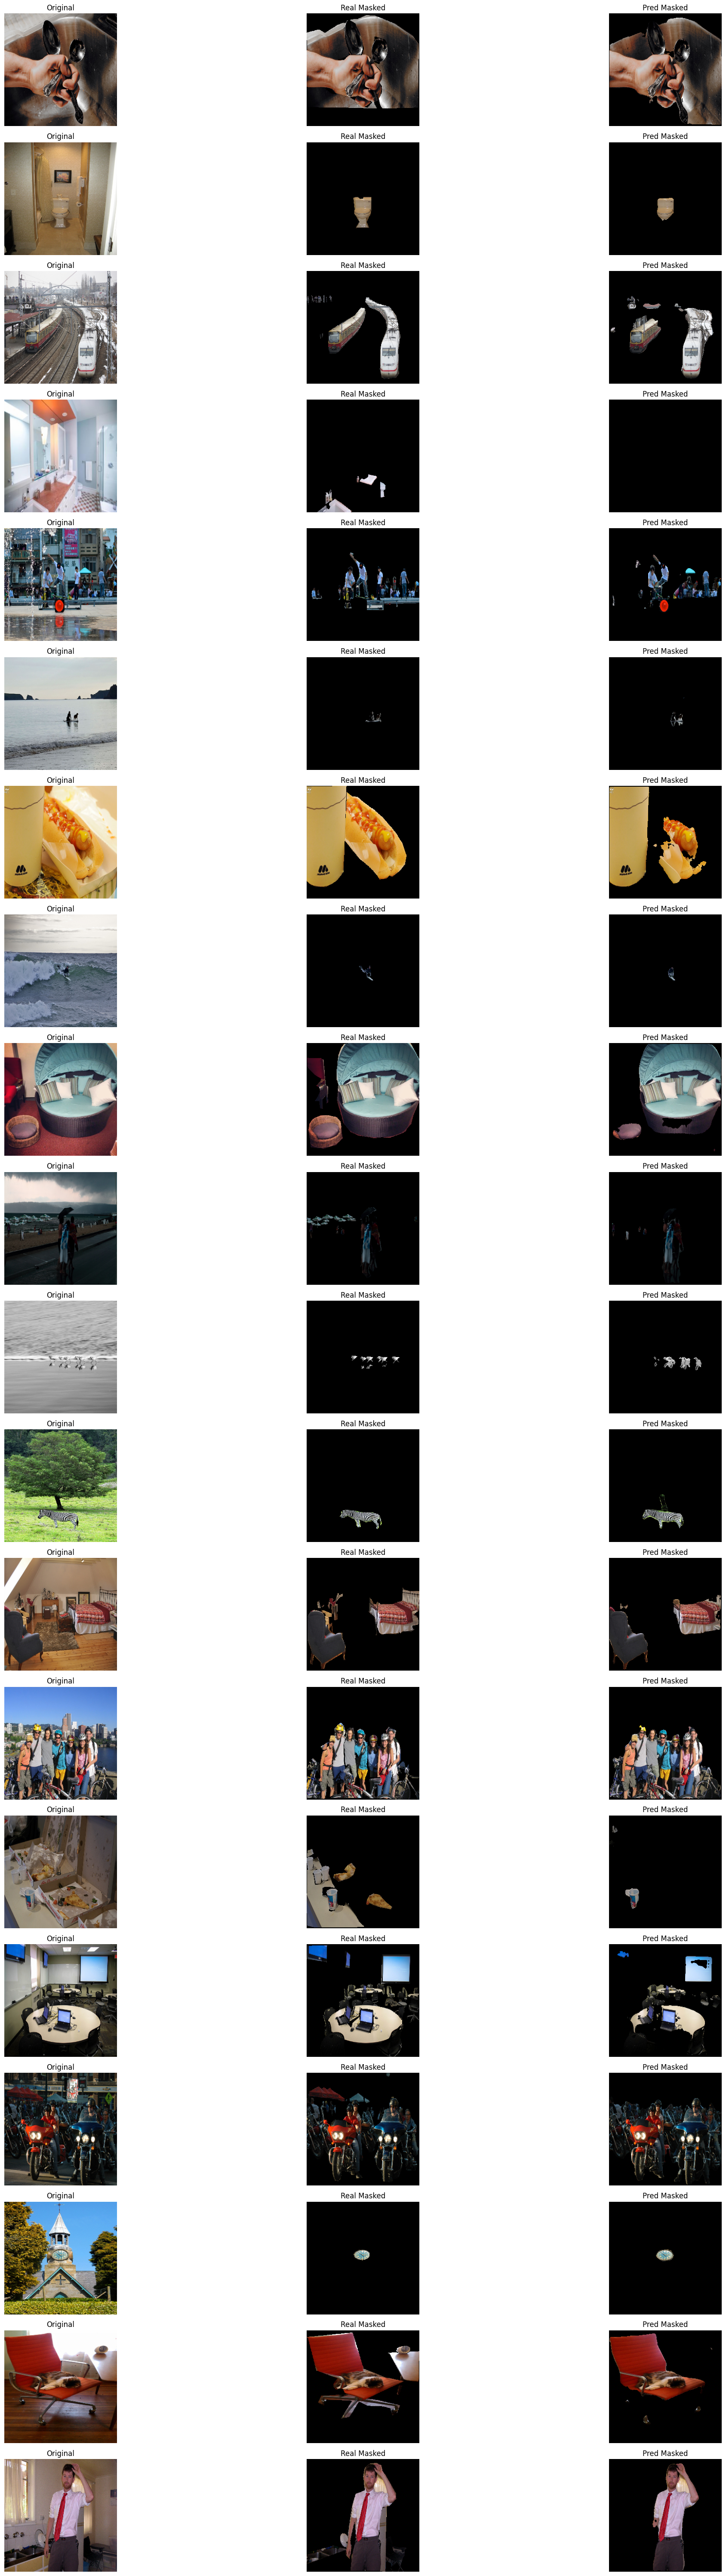

In [ ]:
def denormalize(x):
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    return (x * std) + mean

num_samples = 20
rows = 20
cols = 3

plt.figure(figsize=(25, 60))

model.eval()

for i in range(num_samples):

    idx = random.randint(0, len(val_set)-1)
    img, true_mask = val_set[idx]

    img_np = denormalize(img.permute(1,2,0).cpu().numpy())
    img_np = np.clip(img_np, 0, 1)

    true_mask_np = true_mask.squeeze().cpu().numpy().astype(np.uint8)

    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))
        pred_mask = (torch.sigmoid(pred).cpu().squeeze().numpy() > 0.5).astype(np.uint8)

    real_masked = img_np.copy()
    real_masked[true_mask_np == 0] = 0

    pred_masked = img_np.copy()
    pred_masked[pred_mask == 0] = 0

    plt.subplot(rows, cols, i*cols + 1)
    plt.imshow(img_np)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(rows, cols, i*cols + 2)
    plt.imshow(real_masked)
    plt.title("Real Masked")
    plt.axis("off")

    plt.subplot(rows, cols, i*cols + 3)
    plt.imshow(pred_masked)
    plt.title("Pred Masked")
    plt.axis("off")

plt.tight_layout()
plt.show()
